In [6]:
import numpy as np
import pandas as pd
import imageio
import os
import shutil
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score
# import higra as hg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
import cv2
import sys
sys.path.append('../../resuneta/src')

from bound_dist import get_boundary

# Test set metrics

In [3]:
# shared function(s)
def get_mask(extent, boundary_kernel_size=(2,2)):
    boundary = get_boundary(extent, kernel_size=boundary_kernel_size)
    mask = np.array((extent + boundary) >= 1, dtype=np.uint8)
    return mask

## Planet: consensus

In [9]:
def get_test_set_mcc(image_ids, pred_folder_name, 
                     label_folder_name='../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/',
                     threshold=0.5,
                     codes_to_keep=list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]):
    labels = []
    predictions = []

    for i, image_id in enumerate(image_ids):
        if i % 10 == 0:
            print(i)
        extent = imageio.imread(os.path.join(label_folder_name, image_id))[:256,:256]
        extent = np.array(np.isin(extent, codes_to_keep), dtype=np.uint8)
        pred = np.load(os.path.join('../results/partial-france/', 
                                    pred_folder_name,
                                    'extent_predictions',
                                    '{}.npy'.format(image_id[:-4])))

        mask = get_mask(extent)
        mask_flat = mask.flatten()

        indices = np.where(mask_flat == 1)[0]
        extent_flat = extent.flatten()
        field_and_border = extent_flat[indices]

        pred_flat = pred.flatten()
        prediction = pred_flat[indices]
        prediction = np.array(prediction > threshold, dtype=np.uint8)

        labels = labels + list(field_and_border)
        predictions = predictions + list(prediction)
        
    return matthews_corrcoef(labels, predictions)

In [5]:
def get_test_set_metrics(image_ids, pred_folder_name, 
                     label_folder_name='../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/',
                     threshold=0.5,
                     codes_to_keep=list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]):
    labels = []
    predictions = []

    for i, image_id in enumerate(image_ids):
        if i % 10 == 0:
            print(i)
        extent = imageio.imread(os.path.join(label_folder_name, image_id))[:256,:256]
        extent = np.array(np.isin(extent, codes_to_keep), dtype=np.uint8)
        pred = np.load(os.path.join('../results/partial-france/', 
                                    pred_folder_name,
                                    'extent_predictions',
                                    '{}.npy'.format(image_id[:-4])))

        mask = get_mask(extent)
        mask_flat = mask.flatten()

        indices = np.where(mask_flat == 1)[0]
        extent_flat = extent.flatten()
        field_and_border = extent_flat[indices]

        pred_flat = pred.flatten()
        prediction = pred_flat[indices]
        prediction = np.array(prediction > threshold, dtype=np.uint8)

        labels = labels + list(field_and_border)
        predictions = predictions + list(prediction)
        
    return matthews_corrcoef(labels, predictions), accuracy_score(labels, predictions), f1_score(labels, predictions)

In [45]:
splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
image_ids = splits_df[splits_df['fold'] == 'val']['image_id'].values
# image_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values
splits_df.head()

image_id        lat       lon   fold
0    00000  45.170360  3.531187   test
1    00001  49.557181  0.591338  train
2    00002  46.215638  4.184958   test
3    00003  45.694366  1.540555   test
4    00004  44.683271  2.670917  train

### Original resolution, full labels

In [16]:
def get_full_label_test_set_metrics(
    image_ids, pred_folder_name, 
    label_folder_name='../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/',
    threshold=0.5, codes_to_keep=list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]):
    
    labels = []
    predictions = []

    for i, image_id in enumerate(image_ids):
        if i % 10 == 0:
            print(i)
        extent = imageio.imread(os.path.join(label_folder_name, image_id))[:256,:256]
        extent = np.array(np.isin(extent, codes_to_keep), dtype=np.uint8)
        pred = np.load(os.path.join('../results/full-france/', 
                                    pred_folder_name,
                                    'extent_predictions',
                                    '{}.npy'.format(image_id[:-4])))

        pred_flat = pred.flatten()
        prediction = np.array(pred_flat > threshold, dtype=np.uint8)

        labels = labels + list(extent.flatten())
        predictions = predictions + list(prediction)
        
    return matthews_corrcoef(labels, predictions), accuracy_score(labels, predictions), f1_score(labels, predictions)

In [47]:
# ==================== USER SETTINGS ==================== #
# trained on 3-month separate France original resolution
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2'
# ======================================================= #

base_dir = '../results/full-france/{}'.format(model_name)
months = ['2019_04', '2019_07', '2019_10']

for subfolder in ['extent_predictions', 'boundary_predictions']:
    consensus_dir = os.path.join(base_dir, 'consensus_AprJulOct', subfolder)

    if not os.path.exists(consensus_dir):
        os.makedirs(consensus_dir)

    plot = False
    if plot:
        fig, ax = plt.subplots(4, 4, figsize=(16, 16))

    for image_id in image_ids:

        exists = True
        pred = np.zeros((len(months), 256, 256))
        for m, month in enumerate(months):
            pred_path = '../results/full-france/{}/{}/{}/{}_{}.npy'.format(
                model_name, month, subfolder, image_id, month)
#             print(pred_path)
            if os.path.exists(pred_path):
                print(image_id)
                pred_month = np.load(pred_path)
                pred[m] = pred_month

                if plot:
                    r = m // 4
                    c = m % 4
                    ax[r,c].imshow(pred_month, cmap='Greys_r')
            else:
                exists = False

        pred_consensus = np.mean(pred, axis=0)

        if plot:
            ax[-1,0].imshow(pred_consensus, cmap='Greys_r')
            plt.show()

        if exists:
            np.save(os.path.join(consensus_dir, image_id + '.npy'), pred_consensus)

00016
00016
00016
00032
00032
00032
00034
00034
00034
00035
00035
00035
00051
00051
00051
00060
00060
00060
00064
00064
00064
00065
00065
00065
00073
00073
00073
00075
00075
00075
00077
00077
00077
00078
00078
00078
00084
00084
00084
00092
00092
00092
00094
00094
00094
00098
00098
00098
00101
00101
00101
00102
00102
00102
00108
00108
00108
00113
00113
00113
00119
00119
00119
00124
00124
00124
00127
00127
00127
00130
00130
00130
00132
00132
00132
00134
00134
00134
00154
00154
00154
00160
00160
00160
00169
00169
00169
00181
00181
00181
00190
00190
00190
00195
00195
00195
00198
00198
00198
00201
00201
00201
00203
00203
00203
00206
00206
00206
00212
00212
00212
00228
00228
00228
00237
00237
00237
00244
00244
00244
00263
00263
00263
00270
00270
00270
00273
00273
00273
00276
00276
00276
00277
00277
00277
00283
00283
00283
00287
00287
00287
00288
00288
00288
00292
00292
00292
00299
00299
00299
00320
00320
00320
00330
00330
00330
00331
00331
00331
00334
00334
00334
00335
00335
00335
00338
0033

02931
02931
02931
02944
02944
02944
02950
02950
02950
02952
02952
02952
02965
02965
02965
02973
02973
02973
02979
02979
02979
02987
02987
02987
03005
03005
03005
03016
03016
03016
03025
03025
03025
03033
03033
03033
03041
03041
03041
03042
03042
03042
03046
03046
03046
03055
03055
03055
03068
03068
03068
03084
03084
03084
03104
03104
03104
03118
03118
03118
03135
03135
03135
03137
03137
03137
03139
03139
03139
03143
03143
03143
03152
03152
03152
03156
03156
03156
03157
03157
03157
03158
03158
03158
03166
03166
03166
03174
03174
03174
03178
03178
03178
03184
03184
03184
03189
03189
03189
03205
03205
03205
03209
03209
03209
03218
03218
03218
03233
03233
03233
03241
03241
03241
03242
03242
03242
03281
03281
03281
03290
03290
03290
03292
03292
03292
03295
03295
03295
03296
03296
03296
03300
03300
03300
03301
03301
03301
03304
03304
03304
03317
03317
03317
03319
03319
03319
03323
03323
03323
03326
03326
03326
03328
03328
03328
03330
03330
03330
03343
03343
03343
03345
03345
03345
03357
0335

06048
06048
06049
06049
06049
06061
06061
06061
06063
06063
06063
06064
06064
06064
06068
06068
06068
06070
06070
06070
06077
06077
06077
06079
06079
06079
06083
06083
06083
06084
06084
06084
06103
06103
06103
06104
06104
06104
06106
06106
06106
06109
06109
06109
06117
06117
06117
06118
06118
06118
06127
06127
06127
06130
06130
06130
06134
06134
06134
06147
06147
06147
06154
06154
06154
06162
06162
06162
06185
06185
06185
06193
06193
06193
06194
06194
06194
06204
06204
06204
06214
06214
06214
06226
06226
06226
06234
06234
06234
06239
06239
06239
06241
06241
06241
06242
06242
06242
06244
06244
06244
06247
06247
06247
06252
06252
06252
06256
06256
06256
06261
06261
06261
06266
06266
06266
06272
06272
06272
06280
06280
06280
06283
06283
06283
06292
06292
06292
06316
06316
06316
06340
06340
06340
06351
06351
06351
06359
06359
06359
06366
06366
06366
06372
06372
06372
06374
06374
06374
06375
06375
06375
06386
06386
06386
06388
06388
06388
06408
06408
06408
06422
06422
06422
06431
06431
0643

09190
09190
09208
09208
09208
09213
09213
09213
09222
09222
09222
09228
09228
09228
09232
09232
09232
09237
09237
09237
09243
09243
09243
09245
09245
09245
09270
09270
09270
09273
09273
09273
09296
09296
09296
09300
09300
09300
09303
09303
09303
09311
09311
09311
09319
09319
09319
09320
09320
09320
09322
09322
09322
09330
09330
09330
09333
09333
09333
09335
09335
09335
09344
09344
09344
09349
09349
09349
09364
09364
09364
09367
09367
09367
09380
09380
09380
09382
09382
09382
09393
09393
09393
09396
09396
09396
09401
09401
09401
09402
09402
09402
09403
09403
09403
09412
09412
09412
09415
09415
09415
09418
09418
09418
09425
09425
09425
09426
09426
09426
09444
09444
09444
09465
09465
09465
09478
09478
09478
09487
09487
09487
09490
09490
09490
09498
09498
09498
09502
09502
09502
09506
09506
09506
09509
09509
09509
09512
09512
09512
09514
09514
09514
09515
09515
09515
09519
09519
09519
09520
09520
09520
09527
09527
09527
09540
09540
09540
09541
09541
09541
09551
09551
09551
09562
09562
0956

02025
02025
02030
02030
02030
02032
02032
02032
02059
02059
02059
02071
02071
02071
02075
02075
02075
02095
02095
02095
02103
02103
02103
02113
02113
02113
02117
02117
02117
02123
02123
02123
02124
02124
02124
02130
02130
02130
02132
02132
02132
02135
02135
02135
02142
02142
02142
02147
02147
02147
02157
02157
02157
02164
02164
02164
02165
02165
02165
02166
02166
02166
02185
02185
02185
02195
02195
02195
02206
02206
02206
02207
02207
02207
02208
02208
02208
02216
02216
02216
02217
02217
02217
02226
02226
02226
02233
02233
02233
02239
02239
02239
02244
02244
02244
02257
02257
02257
02260
02260
02260
02265
02265
02265
02269
02269
02269
02271
02271
02271
02272
02272
02272
02283
02283
02283
02299
02299
02299
02312
02312
02312
02319
02319
02319
02323
02323
02323
02328
02328
02328
02329
02329
02329
02333
02333
02333
02344
02344
02344
02359
02359
02359
02365
02365
02365
02369
02369
02369
02372
02372
02372
02381
02381
02381
02386
02386
02386
02391
02391
02391
02393
02393
02393
02394
02394
0239

05176
05178
05178
05178
05181
05181
05181
05187
05187
05187
05189
05189
05189
05190
05190
05190
05194
05194
05194
05217
05217
05217
05222
05222
05222
05228
05228
05228
05235
05235
05235
05236
05236
05236
05238
05238
05238
05241
05241
05241
05242
05242
05242
05245
05245
05245
05246
05246
05246
05263
05263
05263
05286
05286
05286
05287
05287
05287
05289
05289
05289
05296
05296
05296
05298
05298
05298
05301
05301
05301
05305
05305
05305
05310
05310
05310
05322
05322
05322
05333
05333
05333
05341
05341
05341
05342
05342
05342
05348
05348
05348
05353
05353
05353
05358
05358
05358
05371
05371
05371
05374
05374
05374
05377
05377
05377
05382
05382
05382
05392
05392
05392
05406
05406
05406
05413
05413
05413
05435
05435
05435
05441
05441
05441
05445
05445
05445
05449
05449
05449
05452
05452
05452
05454
05454
05454
05461
05461
05461
05462
05462
05462
05477
05477
05477
05480
05480
05480
05482
05482
05482
05487
05487
05487
05512
05512
05512
05520
05520
05520
05525
05525
05525
05528
05528
05528
0554

08365
08365
08368
08368
08368
08371
08371
08371
08379
08379
08379
08382
08382
08382
08388
08388
08388
08405
08405
08405
08408
08408
08408
08410
08410
08410
08417
08417
08417
08425
08425
08425
08427
08427
08427
08428
08428
08428
08430
08430
08430
08436
08436
08436
08437
08437
08437
08440
08440
08440
08446
08446
08446
08452
08452
08452
08460
08460
08460
08468
08468
08468
08495
08495
08495
08504
08504
08504
08514
08514
08514
08516
08516
08516
08519
08519
08519
08529
08529
08529
08542
08542
08542
08554
08554
08554
08556
08556
08556
08558
08558
08558
08562
08562
08562
08568
08568
08568
08573
08573
08573
08585
08585
08585
08587
08587
08587
08589
08589
08589
08593
08593
08593
08608
08608
08608
08610
08610
08610
08611
08611
08611
08640
08640
08640
08647
08647
08647
08650
08650
08650
08661
08661
08661
08663
08663
08663
08665
08665
08665
08669
08669
08669
08672
08672
08672
08674
08674
08674
08685
08685
08685
08694
08694
08694
08698
08698
08698
08704
08704
08704
08706
08706
08706
08712
08712
0871

In [53]:
# original resolution, full labels
mccs = []
threshs = np.linspace(0.45, 0.6, 16)
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/original_thickness2/'))
test_images = splits_df[splits_df['fold'] == 'val']['image_id'].values
image_ids = np.random.choice([x for x in image_ids if x[:5] in test_images], 100, replace=False)
for thresh in threshs:
    print(thresh)
    mcc, _, _ = get_full_label_test_set_metrics(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct',
        label_folder_name='../data/planet/france/extent_labels/1250px/original_thickness2/',
        threshold=thresh
    )
    mccs.append(mcc)

0.45
0
10
20
30
40
50
60
70
80
90
0.46
0
10
20
30
40
50
60
70
80
90
0.47000000000000003
0
10
20
30
40
50
60
70
80
90
0.48
0
10
20
30
40
50
60
70
80
90
0.49
0
10
20
30
40
50
60
70
80
90
0.5
0
10
20
30
40
50
60
70
80
90
0.51
0
10
20
30
40
50
60
70
80
90
0.52
0
10
20
30
40
50
60
70
80
90
0.53
0
10
20
30
40
50
60
70
80
90
0.54
0
10
20
30
40
50
60
70
80
90
0.55
0
10
20
30
40
50
60
70
80
90
0.56
0
10
20
30
40
50
60
70
80
90
0.57
0
10
20
30
40
50
60
70
80
90
0.58
0
10
20
30
40
50
60
70
80
90
0.59
0
10
20
30
40
50
60
70
80
90
0.6
0
10
20
30
40
50
60
70
80
90


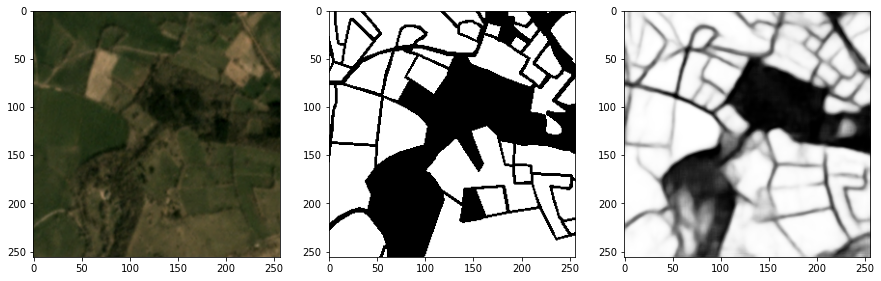

In [48]:
codes_to_keep=list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]
img = imageio.imread('../data/planet/france/1250px/original/00000_2019_04.tif')[:256,:256]
label = imageio.imread('../data/planet/france/extent_labels/1250px/original_thickness2/00000.png')[:256,:256]
label = np.array(np.isin(label, codes_to_keep), dtype=np.uint8)
pred = np.load('../results/full-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/extent_predictions/00000.npy')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(label, cmap='Greys_r')
ax[2].imshow(pred, cmap='Greys_r')
plt.show()

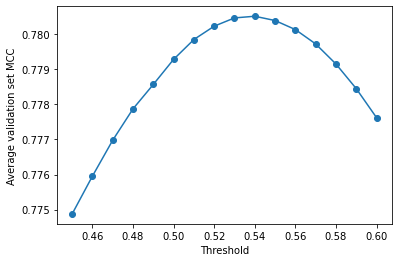

In [54]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [55]:
np.array(threshs)[np.argmax(mccs)]

0.54

In [56]:
# ALL METRICS
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/original_thickness2/'))
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]
mcc, acc, f1 = get_full_label_test_set_metrics(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct',
    label_folder_name='../data/planet/france/extent_labels/1250px/original_thickness2/',
    threshold=0.54
)
print("Test set MCC: {:.3f}, accuracy: {:.3f}, f1-score: {:.3f}".format(mcc, acc, f1))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
Test set MCC: 0.778, accuracy: 0.889, f1-score: 0.883


### Original resolution

In [8]:
# ==================== USER SETTINGS ==================== #
# trained on 3-month separate France original resolution
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2'
# model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759'
# ======================================================= #

base_dir = '../results/partial-france/{}'.format(model_name)
months = ['2019_04', '2019_07', '2019_10']

for subfolder in ['extent_predictions', 'boundary_predictions']:
    consensus_dir = os.path.join(base_dir, 'consensus_AprJulOct', subfolder)

    if not os.path.exists(consensus_dir):
        os.makedirs(consensus_dir)

    plot = False
    if plot:
        fig, ax = plt.subplots(4, 4, figsize=(16, 16))

    for image_id in image_ids:

        exists = True
        pred = np.zeros((len(months), 256, 256))
        for m, month in enumerate(months):
            pred_path = '../results/partial-france/{}/{}/{}/{}_{}.npy'.format(
                model_name, month, subfolder, image_id, month)
            if os.path.exists(pred_path):
                print(image_id)
                pred_month = np.load(pred_path)
                pred[m] = pred_month

                if plot:
                    r = m // 4
                    c = m % 4
                    ax[r,c].imshow(pred_month, cmap='Greys_r')
            else:
                exists = False

        pred_consensus = np.mean(pred, axis=0)

        if plot:
            ax[-1,0].imshow(pred_consensus, cmap='Greys_r')
            plt.show()

        if exists:
            np.save(os.path.join(consensus_dir, image_id + '.npy'), pred_consensus)

00016
00016
00016
00032
00032
00032
00034
00034
00034
00035
00035
00035
00051
00051
00051
00060
00060
00060
00064
00064
00064
00065
00065
00065
00073
00073
00073
00075
00075
00075
00077
00077
00077
00078
00078
00078
00084
00084
00084
00092
00092
00092
00094
00094
00094
00098
00098
00098
00101
00101
00101
00102
00102
00102
00108
00108
00108
00113
00113
00113
00119
00119
00119
00124
00124
00124
00127
00127
00127
00130
00130
00130
00132
00132
00132
00134
00134
00134
00154
00154
00154
00160
00160
00160
00169
00169
00169
00181
00181
00181
00190
00190
00190
00195
00195
00195
00198
00198
00198
00201
00201
00201
00203
00203
00203
00206
00206
00206
00212
00212
00212
00228
00228
00228
00237
00237
00237
00244
00244
00244
00263
00263
00263
00270
00270
00270
00273
00273
00273
00276
00276
00276
00277
00277
00277
00283
00283
00283
00287
00287
00287
00288
00288
00288
00292
00292
00292
00299
00299
00299
00320
00320
00320
00330
00330
00330
00331
00331
00331
00334
00334
00334
00335
00335
00335
00338
0033

03005
03016
03016
03016
03025
03025
03025
03033
03033
03033
03041
03041
03041
03042
03042
03042
03046
03046
03046
03055
03055
03055
03068
03068
03068
03084
03084
03084
03104
03104
03104
03118
03118
03118
03135
03135
03135
03137
03137
03137
03139
03139
03139
03143
03143
03143
03152
03152
03152
03156
03156
03156
03157
03157
03157
03158
03158
03158
03166
03166
03166
03174
03174
03174
03178
03178
03178
03184
03184
03184
03189
03189
03189
03205
03205
03205
03209
03209
03209
03218
03218
03218
03233
03233
03233
03241
03241
03241
03242
03242
03242
03281
03281
03281
03290
03290
03290
03292
03292
03292
03295
03295
03295
03296
03296
03296
03300
03300
03300
03301
03301
03301
03304
03304
03304
03317
03317
03317
03319
03319
03319
03323
03323
03323
03326
03326
03326
03328
03328
03328
03330
03330
03330
03343
03343
03343
03345
03345
03345
03357
03357
03357
03360
03360
03360
03373
03373
03373
03383
03383
03383
03386
03386
03386
03395
03395
03395
03407
03407
03407
03408
03408
03408
03419
03419
03419
0342

06063
06063
06063
06064
06064
06064
06068
06068
06068
06070
06070
06070
06077
06077
06077
06079
06079
06079
06083
06083
06083
06084
06084
06084
06103
06103
06103
06104
06104
06104
06106
06106
06106
06109
06109
06109
06117
06117
06117
06118
06118
06118
06127
06127
06127
06130
06130
06130
06134
06134
06134
06147
06147
06147
06154
06154
06154
06162
06162
06162
06185
06185
06185
06193
06193
06193
06194
06194
06194
06204
06204
06204
06214
06214
06214
06226
06226
06226
06234
06234
06234
06239
06239
06239
06241
06241
06241
06242
06242
06242
06244
06244
06244
06247
06247
06247
06252
06252
06252
06256
06256
06256
06261
06261
06261
06266
06266
06266
06272
06272
06272
06280
06280
06280
06283
06283
06283
06292
06292
06292
06316
06316
06316
06340
06340
06340
06351
06351
06351
06359
06359
06359
06366
06366
06366
06372
06372
06372
06374
06374
06374
06375
06375
06375
06386
06386
06386
06388
06388
06388
06408
06408
06408
06422
06422
06422
06431
06431
06431
06445
06445
06445
06449
06449
06449
06451
0645

09076
09076
09076
09082
09082
09082
09085
09085
09085
09116
09116
09116
09118
09118
09118
09119
09119
09119
09120
09120
09120
09125
09125
09125
09129
09129
09129
09135
09135
09135
09138
09138
09138
09152
09152
09152
09166
09166
09166
09175
09175
09175
09180
09180
09180
09183
09183
09183
09184
09184
09184
09190
09190
09190
09208
09208
09208
09213
09213
09213
09222
09222
09222
09228
09228
09228
09232
09232
09232
09237
09237
09237
09243
09243
09243
09245
09245
09245
09270
09270
09270
09273
09273
09273
09296
09296
09296
09300
09300
09300
09303
09303
09303
09311
09311
09311
09319
09319
09319
09320
09320
09320
09322
09322
09322
09330
09330
09330
09333
09333
09333
09335
09335
09335
09344
09344
09344
09349
09349
09349
09364
09364
09364
09367
09367
09367
09380
09380
09380
09382
09382
09382
09393
09393
09393
09396
09396
09396
09401
09401
09401
09402
09402
09402
09403
09403
09403
09412
09412
09412
09415
09415
09415
09418
09418
09418
09425
09425
09425
09426
09426
09426
09444
09444
09444
09465
0946

01907
01910
01910
01910
01915
01915
01915
01919
01919
01919
01930
01930
01930
01933
01933
01933
01937
01937
01937
01938
01938
01938
01945
01945
01945
01960
01960
01960
01963
01963
01963
01970
01970
01970
01980
01980
01980
02002
02002
02002
02013
02013
02013
02024
02024
02024
02025
02025
02025
02030
02030
02030
02032
02032
02032
02059
02059
02059
02071
02071
02071
02075
02075
02075
02095
02095
02095
02103
02103
02103
02113
02113
02113
02117
02117
02117
02123
02123
02123
02124
02124
02124
02130
02130
02130
02132
02132
02132
02135
02135
02135
02142
02142
02142
02147
02147
02147
02157
02157
02157
02164
02164
02164
02165
02165
02165
02166
02166
02166
02185
02185
02185
02195
02195
02195
02206
02206
02206
02207
02207
02207
02208
02208
02208
02216
02216
02216
02217
02217
02217
02226
02226
02226
02233
02233
02233
02239
02239
02239
02244
02244
02244
02257
02257
02257
02260
02260
02260
02265
02265
02265
02269
02269
02269
02271
02271
02271
02272
02272
02272
02283
02283
02283
02299
02299
02299
0231

04983
04993
04993
04993
04995
04995
04995
05000
05000
05000
05024
05024
05024
05025
05025
05025
05032
05032
05032
05046
05046
05046
05050
05050
05050
05054
05054
05054
05056
05056
05056
05059
05059
05059
05065
05065
05065
05067
05067
05067
05069
05069
05069
05071
05071
05071
05072
05072
05072
05075
05075
05075
05078
05078
05078
05079
05079
05079
05084
05084
05084
05090
05090
05090
05106
05106
05106
05126
05126
05126
05128
05128
05128
05131
05131
05131
05132
05132
05132
05133
05133
05133
05146
05146
05146
05150
05150
05150
05156
05156
05156
05157
05157
05157
05162
05162
05162
05173
05173
05173
05174
05174
05174
05176
05176
05176
05178
05178
05178
05181
05181
05181
05187
05187
05187
05189
05189
05189
05190
05190
05190
05194
05194
05194
05217
05217
05217
05222
05222
05222
05228
05228
05228
05235
05235
05235
05236
05236
05236
05238
05238
05238
05241
05241
05241
05242
05242
05242
05245
05245
05245
05246
05246
05246
05263
05263
05263
05286
05286
05286
05287
05287
05287
05289
05289
05289
0529

08163
08163
08174
08174
08174
08176
08176
08176
08192
08192
08192
08197
08197
08197
08198
08198
08198
08210
08210
08210
08213
08213
08213
08220
08220
08220
08227
08227
08227
08230
08230
08230
08234
08234
08234
08235
08235
08235
08239
08239
08239
08244
08244
08244
08245
08245
08245
08248
08248
08248
08250
08250
08250
08258
08258
08258
08262
08262
08262
08276
08276
08276
08282
08282
08282
08285
08285
08285
08286
08286
08286
08288
08288
08288
08293
08293
08293
08294
08294
08294
08297
08297
08297
08298
08298
08298
08300
08300
08300
08308
08308
08308
08309
08309
08309
08326
08326
08326
08334
08334
08334
08338
08338
08338
08343
08343
08343
08352
08352
08352
08356
08356
08356
08357
08357
08357
08360
08360
08360
08364
08364
08364
08365
08365
08365
08368
08368
08368
08371
08371
08371
08379
08379
08379
08382
08382
08382
08388
08388
08388
08405
08405
08405
08408
08408
08408
08410
08410
08410
08417
08417
08417
08425
08425
08425
08427
08427
08427
08428
08428
08428
08430
08430
08430
08436
08436
0843

### 2x+3x downsampled

In [24]:
# ==================== USER SETTINGS ==================== #
# trained on 3-month separate France 2x+3x downsampled
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759'
# ======================================================= #

base_dir = '../results/partial-france/{}'.format(model_name)
months = ['2019_04', '2019_07', '2019_10']

for subfolder in ['extent_predictions', 'boundary_predictions']:
    consensus_dir = os.path.join(base_dir, 'consensus_AprJulOct', subfolder)

    if not os.path.exists(consensus_dir):
        os.makedirs(consensus_dir)

    plot = False
    if plot:
        fig, ax = plt.subplots(4, 4, figsize=(16, 16))

    for downsample in ['2x', '3x']:
        for image_id in image_ids:
            
            exists = True
            pred = np.zeros((len(months), 256, 256))
            for m, month in enumerate(months):
                # pred_path = '../results/partial-france/{}/{}/{}/{}-{}_{}.npy'.format(
                pred_path = '../results/partial-france/{}/{}/{}/{}_{}-{}.npy'.format(
                    model_name, month, subfolder, image_id, month, downsample)
                if os.path.exists(pred_path):
                    print(image_id)
                    pred_month = np.load(pred_path)
                    pred[m] = pred_month

                    if plot:
                        r = m // 4
                        c = m % 4
                        ax[r,c].imshow(pred_month, cmap='Greys_r')
                else:
                    exists = False

            pred_consensus = np.mean(pred, axis=0)

            if plot:
                ax[-1,0].imshow(pred_consensus, cmap='Greys_r')
                plt.show()

            if exists:
                np.save(os.path.join(consensus_dir, image_id + '-' + downsample + '.npy'), pred_consensus)

00000
00000
00000
00002
00002
00002
00003
00003
00003
00009
00009
00009
00010
00010
00010
00014
00014
00014
00036
00036
00036
00038
00038
00038
00039
00039
00039
00043
00043
00043
00046
00046
00046
00054
00054
00054
00061
00061
00061
00070
00070
00070
00079
00079
00079
00091
00091
00091
00104
00104
00104
00110
00110
00110
00115
00115
00115
00117
00117
00117
00120
00120
00120
00123
00123
00123
00125
00125
00125
00126
00126
00126
00131
00131
00131
00136
00136
00136
00141
00141
00141
00146
00146
00146
00150
00150
00150
00165
00165
00165
00182
00182
00182
00197
00197
00197
00199
00199
00199
00209
00209
00209
00226
00226
00226
00230
00230
00230
00235
00235
00235
00238
00238
00238
00251
00251
00251
00261
00261
00261
00264
00264
00264
00272
00272
00272
00275
00275
00275
00285
00285
00285
00293
00293
00293
00304
00304
00304
00306
00306
00306
00308
00308
00308
00312
00312
00312
00333
00333
00333
00339
00339
00339
00345
00345
00345
00348
00348
00348
00349
00349
00349
00352
00352
00352
00358
0035

02891
02891
02891
02892
02892
02892
02894
02894
02894
02899
02899
02899
02908
02908
02908
02912
02912
02912
02913
02913
02913
02915
02915
02915
02916
02916
02916
02935
02935
02935
02939
02939
02939
02941
02941
02941
02945
02945
02945
02946
02946
02946
02958
02958
02958
02966
02966
02966
02974
02974
02974
02986
02986
02986
02990
02990
02990
02991
02991
02991
02995
02995
02995
03006
03006
03006
03009
03009
03009
03015
03015
03015
03030
03030
03030
03051
03051
03051
03054
03054
03054
03057
03057
03057
03058
03058
03058
03059
03059
03059
03080
03080
03080
03083
03083
03083
03085
03085
03085
03096
03096
03096
03098
03098
03098
03102
03102
03102
03107
03107
03107
03108
03108
03108
03109
03109
03109
03128
03128
03128
03131
03131
03131
03134
03134
03134
03141
03141
03141
03154
03154
03154
03162
03162
03162
03190
03190
03190
03194
03194
03194
03198
03198
03198
03200
03200
03200
03201
03201
03201
03208
03208
03208
03212
03212
03212
03216
03216
03216
03217
03217
03217
03231
03231
03231
03254
0325

05912
05912
05912
05919
05919
05919
05931
05931
05931
05935
05935
05935
05940
05940
05940
05959
05959
05959
05963
05963
05963
05979
05979
05979
06003
06003
06003
06010
06010
06010
06013
06013
06013
06018
06018
06018
06020
06020
06020
06021
06021
06021
06023
06023
06023
06025
06025
06025
06029
06029
06029
06044
06044
06044
06046
06046
06046
06050
06050
06050
06052
06052
06052
06058
06058
06058
06088
06088
06088
06102
06102
06102
06110
06110
06110
06111
06111
06111
06123
06123
06123
06124
06124
06124
06132
06132
06132
06140
06140
06140
06144
06144
06144
06158
06158
06158
06168
06168
06168
06172
06172
06172
06174
06174
06174
06187
06187
06187
06188
06188
06188
06192
06192
06192
06200
06200
06200
06216
06216
06216
06219
06219
06219
06228
06228
06228
06231
06231
06231
06237
06237
06237
06246
06246
06246
06251
06251
06251
06277
06277
06277
06279
06279
06279
06289
06289
06289
06291
06291
06291
06293
06293
06293
06309
06309
06309
06311
06311
06311
06314
06314
06314
06315
06315
06315
06320
0632

08836
08836
08836
08839
08839
08839
08843
08843
08843
08849
08849
08849
08878
08878
08878
08879
08879
08879
08915
08915
08915
08922
08922
08922
08924
08924
08924
08934
08934
08934
08937
08937
08937
08938
08938
08938
08944
08944
08944
08947
08947
08947
08963
08963
08963
08964
08964
08964
08970
08970
08970
08979
08979
08979
08982
08982
08982
08993
08993
08993
08998
08998
08998
09006
09006
09006
09016
09016
09016
09017
09017
09017
09018
09018
09018
09023
09023
09023
09029
09029
09029
09032
09032
09032
09037
09037
09037
09041
09041
09041
09044
09044
09044
09047
09047
09047
09055
09055
09055
09057
09057
09057
09061
09061
09061
09063
09063
09063
09068
09068
09068
09075
09075
09075
09081
09081
09081
09096
09096
09096
09099
09099
09099
09103
09103
09103
09106
09106
09106
09121
09121
09121
09126
09126
09126
09141
09141
09141
09144
09144
09144
09145
09145
09145
09146
09146
09146
09149
09149
09149
09154
09154
09154
09161
09161
09161
09167
09167
09167
09170
09170
09170
09172
09172
09172
09173
0917

01805
01809
01809
01809
01821
01821
01821
01822
01822
01822
01825
01825
01825
01842
01842
01842
01850
01850
01850
01853
01853
01853
01863
01863
01863
01877
01877
01877
01884
01884
01884
01885
01885
01885
01886
01886
01886
01889
01889
01889
01905
01905
01905
01920
01920
01920
01921
01921
01921
01928
01928
01928
01932
01932
01932
01942
01942
01942
01943
01943
01943
01948
01948
01948
01956
01956
01956
01961
01961
01961
01962
01962
01962
01981
01981
01981
01985
01985
01985
01989
01989
01989
01992
01992
01992
02006
02006
02006
02012
02012
02012
02017
02017
02017
02022
02022
02022
02023
02023
02023
02034
02034
02034
02042
02042
02042
02047
02047
02047
02057
02057
02057
02070
02070
02070
02079
02079
02079
02090
02090
02090
02094
02094
02094
02106
02106
02106
02108
02108
02108
02109
02109
02109
02121
02121
02121
02125
02125
02125
02127
02127
02127
02141
02141
02141
02149
02149
02149
02150
02150
02150
02154
02154
02154
02161
02161
02161
02180
02180
02180
02187
02187
02187
02190
02190
02190
0220

04858
04858
04865
04865
04865
04879
04879
04879
04890
04890
04890
04892
04892
04892
04895
04895
04895
04897
04897
04897
04912
04912
04912
04913
04913
04913
04928
04928
04928
04936
04936
04936
04940
04940
04940
04941
04941
04941
04963
04963
04963
04966
04966
04966
04977
04977
04977
04978
04978
04978
04985
04985
04985
04987
04987
04987
05004
05004
05004
05005
05005
05005
05011
05011
05011
05014
05014
05014
05021
05021
05021
05043
05043
05043
05052
05052
05052
05060
05060
05060
05061
05061
05061
05076
05076
05076
05080
05080
05080
05085
05085
05085
05089
05089
05089
05098
05098
05098
05103
05103
05103
05104
05104
05104
05114
05114
05114
05121
05121
05121
05123
05123
05123
05136
05136
05136
05138
05138
05138
05143
05143
05143
05148
05148
05148
05159
05159
05159
05164
05164
05164
05186
05186
05186
05192
05192
05192
05201
05201
05201
05202
05202
05202
05203
05203
05203
05204
05204
05204
05214
05214
05214
05230
05230
05230
05254
05254
05254
05260
05260
05260
05261
05261
05261
05262
05262
0526

07682
07694
07694
07694
07699
07699
07699
07701
07701
07701
07709
07709
07709
07716
07716
07716
07720
07720
07720
07722
07722
07722
07724
07724
07724
07727
07727
07727
07730
07730
07730
07738
07738
07738
07742
07742
07742
07747
07747
07747
07751
07751
07751
07752
07752
07752
07763
07763
07763
07775
07775
07775
07782
07782
07782
07802
07802
07802
07805
07805
07805
07810
07810
07810
07811
07811
07811
07823
07823
07823
07831
07831
07831
07837
07837
07837
07840
07840
07840
07842
07842
07842
07852
07852
07852
07870
07870
07870
07881
07881
07881
07885
07885
07885
07900
07900
07900
07902
07902
07902
07910
07910
07910
07912
07912
07912
07922
07922
07922
07923
07923
07923
07929
07929
07929
07935
07935
07935
07942
07942
07942
07957
07957
07957
07958
07958
07958
07966
07966
07966
07970
07970
07970
07974
07974
07974
07991
07991
07991
07995
07995
07995
08005
08005
08005
08008
08008
08008
08010
08010
08010
08019
08019
08019
08028
08028
08028
08030
08030
08030
08036
08036
08036
08038
08038
08038
0804

00644
00644
00644
00645
00645
00645
00647
00647
00647
00648
00648
00648
00652
00652
00652
00661
00661
00661
00665
00665
00665
00666
00666
00666
00674
00674
00674
00689
00689
00689
00692
00692
00692
00713
00713
00713
00715
00715
00715
00731
00731
00731
00735
00735
00735
00741
00741
00741
00742
00742
00742
00748
00748
00748
00751
00751
00751
00758
00758
00758
00761
00761
00761
00764
00764
00764
00771
00771
00771
00780
00780
00780
00794
00794
00794
00800
00800
00800
00818
00818
00818
00821
00821
00821
00832
00832
00832
00842
00842
00842
00844
00844
00844
00845
00845
00845
00851
00851
00851
00855
00855
00855
00859
00859
00859
00862
00862
00862
00863
00863
00863
00865
00865
00865
00871
00871
00871
00878
00878
00878
00887
00887
00887
00896
00896
00896
00897
00897
00897
00901
00901
00901
00911
00911
00911
00920
00920
00920
00932
00932
00932
00937
00937
00937
00943
00943
00943
00960
00960
00960
00970
00970
00970
00971
00971
00971
00984
00984
00984
00986
00986
00986
00988
00988
00988
00989
0098

03651
03651
03651
03653
03653
03653
03659
03659
03659
03662
03662
03662
03674
03674
03674
03697
03697
03697
03702
03702
03702
03709
03709
03709
03719
03719
03719
03723
03723
03723
03726
03726
03726
03733
03733
03733
03743
03743
03743
03747
03747
03747
03755
03755
03755
03767
03767
03767
03773
03773
03773
03774
03774
03774
03782
03782
03782
03783
03783
03783
03805
03805
03805
03806
03806
03806
03809
03809
03809
03810
03810
03810
03813
03813
03813
03820
03820
03820
03822
03822
03822
03834
03834
03834
03835
03835
03835
03836
03836
03836
03837
03837
03837
03838
03838
03838
03841
03841
03841
03845
03845
03845
03868
03868
03868
03872
03872
03872
03878
03878
03878
03902
03902
03902
03907
03907
03907
03915
03915
03915
03920
03920
03920
03928
03928
03928
03931
03931
03931
03936
03936
03936
03938
03938
03938
03945
03945
03945
03953
03953
03953
03959
03959
03959
03961
03961
03961
03962
03962
03962
03972
03972
03972
03986
03986
03986
04006
04006
04006
04014
04014
04014
04020
04020
04020
04039
0403

06666
06669
06669
06669
06682
06682
06682
06696
06696
06696
06698
06698
06698
06702
06702
06702
06706
06706
06706
06709
06709
06709
06723
06723
06723
06741
06741
06741
06743
06743
06743
06763
06763
06763
06771
06771
06771
06772
06772
06772
06773
06773
06773
06777
06777
06777
06781
06781
06781
06784
06784
06784
06792
06792
06792
06804
06804
06804
06809
06809
06809
06813
06813
06813
06815
06815
06815
06816
06816
06816
06826
06826
06826
06835
06835
06835
06841
06841
06841
06847
06847
06847
06849
06849
06849
06855
06855
06855
06867
06867
06867
06869
06869
06869
06879
06879
06879
06893
06893
06893
06898
06898
06898
06900
06900
06900
06913
06913
06913
06915
06915
06915
06930
06930
06930
06931
06931
06931
06944
06944
06944
06950
06950
06950
06953
06953
06953
06955
06955
06955
06956
06956
06956
06961
06961
06961
06964
06964
06964
06965
06965
06965
06972
06972
06972
06974
06974
06974
06975
06975
06975
06976
06976
06976
06981
06981
06981
06989
06989
06989
06996
06996
06996
06997
06997
06997
0700

09461
09461
09461
09466
09466
09466
09471
09471
09471
09473
09473
09473
09474
09474
09474
09479
09479
09479
09480
09480
09480
09484
09484
09484
09516
09516
09516
09521
09521
09521
09537
09537
09537
09538
09538
09538
09546
09546
09546
09552
09552
09552
09553
09553
09553
09558
09558
09558
09565
09565
09565
09570
09570
09570
09571
09571
09571
09580
09580
09580
09584
09584
09584
09590
09590
09590
09594
09594
09594
09597
09597
09597
09598
09598
09598
09602
09602
09602
09610
09610
09610
09615
09615
09615
09617
09617
09617
09621
09621
09621
09627
09627
09627
09629
09629
09629
09682
09682
09682
09683
09683
09683
09692
09692
09692
09704
09704
09704
09707
09707
09707
09708
09708
09708
09723
09723
09723
09724
09724
09724
09745
09745
09745
09749
09749
09749
09751
09751
09751
09754
09754
09754
09759
09759
09759
09768
09768
09768
09769
09769
09769
09798
09798
09798
09805
09805
09805
09807
09807
09807
09814
09814
09814
09817
09817
09817
09818
09818
09818
09819
09819
09819
09829
09829
09829
09832
0983

02398
02399
02399
02399
02406
02406
02406
02408
02408
02408
02412
02412
02412
02417
02417
02417
02420
02420
02420
02423
02423
02423
02425
02425
02425
02434
02434
02434
02439
02439
02439
02448
02448
02448
02454
02454
02454
02461
02461
02461
02471
02471
02471
02474
02474
02474
02487
02487
02487
02492
02492
02492
02499
02499
02499
02506
02506
02506
02508
02508
02508
02518
02518
02518
02528
02528
02528
02540
02540
02540
02543
02543
02543
02544
02544
02544
02546
02546
02546
02552
02552
02552
02567
02567
02567
02568
02568
02568
02572
02572
02572
02580
02580
02580
02581
02581
02581
02586
02586
02586
02590
02590
02590
02594
02594
02594
02608
02608
02608
02612
02612
02612
02613
02613
02613
02618
02618
02618
02632
02632
02632
02643
02643
02643
02644
02644
02644
02646
02646
02646
02660
02660
02660
02667
02667
02667
02670
02670
02670
02674
02674
02674
02687
02687
02687
02690
02690
02690
02692
02692
02692
02693
02693
02693
02699
02699
02699
02700
02700
02700
02703
02703
02703
02708
02708
02708
0271

05488
05498
05498
05498
05501
05501
05501
05504
05504
05504
05508
05508
05508
05510
05510
05510
05513
05513
05513
05519
05519
05519
05526
05526
05526
05537
05537
05537
05539
05539
05539
05542
05542
05542
05548
05548
05548
05551
05551
05551
05564
05564
05564
05566
05566
05566
05567
05567
05567
05575
05575
05575
05587
05587
05587
05590
05590
05590
05599
05599
05599
05611
05611
05611
05615
05615
05615
05620
05620
05620
05621
05621
05621
05623
05623
05623
05629
05629
05629
05650
05650
05650
05656
05656
05656
05659
05659
05659
05668
05668
05668
05670
05670
05670
05673
05673
05673
05687
05687
05687
05692
05692
05692
05695
05695
05695
05701
05701
05701
05721
05721
05721
05725
05725
05725
05727
05727
05727
05733
05733
05733
05762
05762
05762
05766
05766
05766
05770
05770
05770
05772
05772
05772
05781
05781
05781
05783
05783
05783
05790
05790
05790
05792
05792
05792
05797
05797
05797
05803
05803
05803
05804
05804
05804
05808
05808
05808
05815
05815
05815
05820
05820
05820
05823
05823
05823
0582

08322
08322
08322
08325
08325
08325
08330
08330
08330
08331
08331
08331
08333
08333
08333
08337
08337
08337
08345
08345
08345
08354
08354
08354
08359
08359
08359
08376
08376
08376
08377
08377
08377
08391
08391
08391
08392
08392
08392
08395
08395
08395
08399
08399
08399
08411
08411
08411
08447
08447
08447
08450
08450
08450
08454
08454
08454
08456
08456
08456
08467
08467
08467
08476
08476
08476
08478
08478
08478
08480
08480
08480
08481
08481
08481
08492
08492
08492
08493
08493
08493
08506
08506
08506
08508
08508
08508
08515
08515
08515
08530
08530
08530
08535
08535
08535
08536
08536
08536
08539
08539
08539
08545
08545
08545
08552
08552
08552
08581
08581
08581
08591
08591
08591
08595
08595
08595
08598
08598
08598
08602
08602
08602
08603
08603
08603
08609
08609
08609
08612
08612
08612
08613
08613
08613
08618
08618
08618
08623
08623
08623
08652
08652
08652
08653
08653
08653
08662
08662
08662
08670
08670
08670
08675
08675
08675
08676
08676
08676
08677
08677
08677
08679
08679
08679
08681
0868

## MCC for entire test set

#### Tune threshold on validation set

##### 3-month consensus

In [48]:
image_ids = os.listdir('../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/')
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]

In [ ]:
# 2x+3x downsampled
# using best thresh 0.58
mcc = get_test_set_mcc(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct',
    label_folder_name='../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/',
    threshold=0.58
)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [ ]:
mcc

In [38]:
# 2x+3x downsampled
mccs = []
threshs = np.linspace(0.5, 0.7, 11)
image_ids = os.listdir('../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/')
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct',
        label_folder_name='../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/',
        threshold=thresh
    )
    mccs.append(mcc)

0.5
0.52
0.54
0.5599999999999999
0.58
0.6
0.62
0.64
0.6599999999999999
0.6799999999999999
0.7


In [40]:
np.array(threshs)[np.argmax(mccs)]

0.58

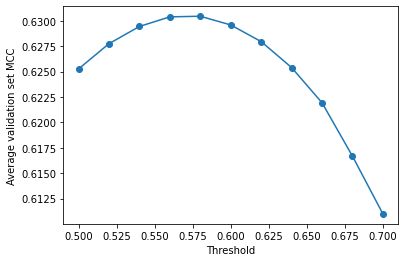

In [39]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [194]:
# original resolution
mccs = []
threshs = np.linspace(0.5, 0.7, 11)
image_ids = sorted(os.listdir('../data/planet/france/sherrie10k/extent_labels/300px/'))
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus_AprJulOct',
        label_folder_name='../data/planet/france/sherrie10k/extent_labels/300px/',
        threshold=thresh
    )
    mccs.append(mcc)

In [196]:
np.array(threshs)[np.argmax(mccs)]

0.74

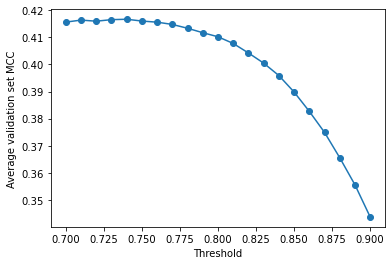

In [195]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

#### Run #2

In [12]:
# original resolution, run #2
mccs = []
threshs = np.linspace(0.5, 0.7, 11)
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/original_thickness2/'))
test_images = splits_df[splits_df['fold'] == 'val']['image_id'].values
image_ids = np.random.choice([x for x in image_ids if x[:5] in test_images], 100, replace=False)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct',
        label_folder_name='../data/planet/france/extent_labels/1250px/original_thickness2/',
        threshold=thresh
    )
    mccs.append(mcc)

0.5
0
10
20
30
40
50
60
70
80
90
0.52
0
10
20
30
40
50
60
70
80
90
0.54
0
10
20
30
40
50
60
70
80
90
0.5599999999999999
0
10
20
30
40
50
60
70
80
90
0.58
0
10
20
30
40
50
60
70
80
90
0.6
0
10
20
30
40
50
60
70
80
90
0.62
0
10
20
30
40
50
60
70
80
90
0.64
0
10
20
30
40
50
60
70
80
90
0.6599999999999999
0
10
20
30
40
50
60
70
80
90
0.6799999999999999
0
10
20
30
40
50
60
70
80
90
0.7
0
10
20
30
40
50
60
70
80
90


In [13]:
np.array(threshs)[np.argmax(mccs)]

0.6599999999999999

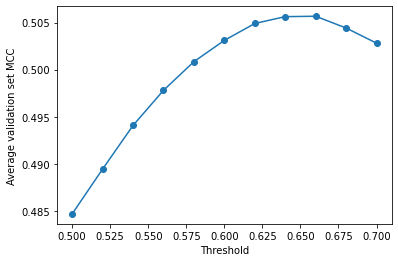

In [14]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [15]:
# using best thresh 0.66
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/original_thickness2/'))
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]
mcc = get_test_set_mcc(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct',
    label_folder_name='../data/planet/france/extent_labels/1250px/original_thickness2/',
    threshold=0.66
)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560


In [17]:
print("Test set MCC: {:0.3f}".format(mcc))

Test set MCC: 0.498


In [8]:
# ALL METRICS
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/original_thickness2/'))
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]
mcc, acc, f1 = get_test_set_metrics(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct',
    label_folder_name='../data/planet/france/extent_labels/1250px/original_thickness2/',
    threshold=0.66
)
print("Test set MCC: {:.3f}, accuracy: {:.3f}, f1-score: {:.3f}".format(mcc, acc, f1))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
Test set MCC: 0.498, accuracy: 0.909, f1-score: 0.950


In [31]:
label_2x_dir = '../data/planet/france/extent_labels/1250px/2x_downsample/'
label_3x_dir = '../data/planet/france/extent_labels/1250px/3x_downsample/'
new_label_dir = '../data/planet/france/extent_labels/1250px/2x-3x_downsample/'
image_ids = sorted(os.listdir(label_2x_dir))

for image_id in image_ids:
    new_image_id = image_id[:5] + '-2x.png'
    src = os.path.join(label_2x_dir, image_id)
    dst = os.path.join(new_label_dir, new_image_id)
    shutil.copyfile(src, dst)
    
    new_image_id = image_id[:5] + '-3x.png'
    src = os.path.join(label_3x_dir, image_id)
    dst = os.path.join(new_label_dir, new_image_id)
    shutil.copyfile(src, dst)

In [33]:
# 2x+3x downsampled
mccs = []
threshs = np.linspace(0.5, 0.7, 11)
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/2x-3x_downsample/'))
test_images = splits_df[splits_df['fold'] == 'val']['image_id'].values
image_ids = np.random.choice([x for x in image_ids if x[:5] in test_images], 100, replace=False)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct',
        label_folder_name='../data/planet/france/extent_labels/1250px/2x-3x_downsample/',
        threshold=thresh
    )
    mccs.append(mcc)

0.5
0
10
20
30
40
50
60
70
80
90
0.52
0
10
20
30
40
50
60
70
80
90
0.54
0
10
20
30
40
50
60
70
80
90
0.5599999999999999
0
10
20
30
40
50
60
70
80
90
0.58
0
10
20
30
40
50
60
70
80
90
0.6
0
10
20
30
40
50
60
70
80
90
0.62
0
10
20
30
40
50
60
70
80
90
0.64
0
10
20
30
40
50
60
70
80
90
0.6599999999999999
0
10
20
30
40
50
60
70
80
90
0.6799999999999999
0
10
20
30
40
50
60
70
80
90
0.7
0
10
20
30
40
50
60
70
80
90


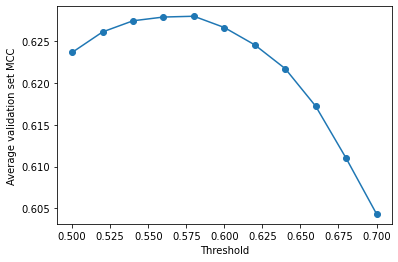

In [35]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [36]:
np.array(threshs)[np.argmax(mccs)]

0.58

In [37]:
# using best thresh 0.58
image_ids = sorted(os.listdir('../data/planet/france/extent_labels/1250px/2x-3x_downsample/'))
test_images = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = [x for x in image_ids if x[:5] in test_images]
mcc = get_test_set_mcc(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct',
    label_folder_name='../data/planet/france/extent_labels/1250px/2x-3x_downsample/',
    threshold=0.58
)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2270
2

In [39]:
print("Test set MCC: {:0.3f}".format(mcc))

Test set MCC: 0.619


##### 3-month stack

In [210]:
# trained on France 2x+3x downsampled stacked
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mccs = []
threshs = np.linspace(0.5, 0.7, 21)
for thresh in threshs:
    mcc = get_test_set_mcc(
        'fractal-resunet_3month-stacked-shuffled_nfilter-32_depth-6_bs-6_lr-0.001_2x-3x-downsampled_fromscratch/',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

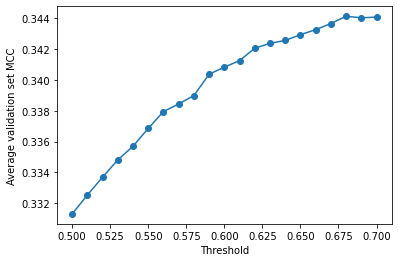

In [211]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()
# best threshold on test set = 
# best MCC at best threshold = 

In [212]:
np.max(mccs)

0.3441375223693795

In [213]:
np.array(threshs)[np.argmax(mccs)]

0.6799999999999999

In [216]:
np.argmax(mccs)

18

## Partial labels experiment

In [11]:
# finetuned
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
model_names = ['fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n{}_finetuned'.format(n) for n in [400]] # 20, 40, 100, 200, 400, 1000
for model_name in model_names:
    mcc = get_test_set_mcc(
        image_ids,
        '{}/consensus_OctDecFeb/'.format(model_name),
        fold=fold,
        threshold=0.5
    )
    np.save('../results/india/GeneralBlockchain/{}/consensus_OctDecFeb_testMCC.npy'.format(model_name), mcc)

In [29]:
# from scratch
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
model_names = ['fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n{}_fromscratch/'.format(n) for n in [20, 40, 100, 200, 400, 1000]]
for model_name in model_names:
    mcc = get_test_set_mcc(
        image_ids,
        '{}/consensus_OctDecFeb/'.format(model_name),
        fold=fold,
        threshold=0.5
    )
    np.save('../results/india/GeneralBlockchain/{}/consensus_OctDecFeb_testMCC.npy'.format(model_name), mcc)

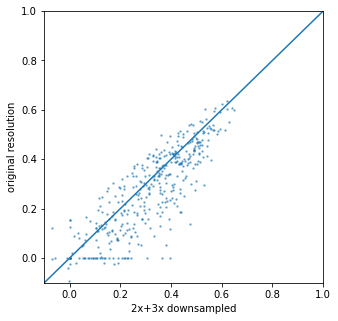

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(image_mccs_2x3x, image_mccs_1x, s=2, alpha=0.5)
plt.xlabel('2x+3x downsampled')
plt.ylabel('original resolution')
plt.plot([-0.1, 1.0], [-0.1, 1.0])
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.show()

In [136]:
# trained on France 2x+3x downsampled separately
labels = []
predictions = []

for image_id in image_ids:
    extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_test/{}.png'.format(image_id))
    pred = np.load(os.path.join('../results/india/GeneralBlockchain/', 
                                'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/2020_12',
                                'extent_predictions',
                                '{}_2020_12.npy'.format(image_id)))

    mask = get_mask(extent)
    mask_flat = mask.flatten()

    indices = np.where(mask_flat == 1)[0]
    extent_flat = extent.flatten()
    field_and_border = extent_flat[indices]

    pred_flat = pred.flatten()
    prediction = pred_flat[indices]
    prediction = np.array(prediction > 0.5, dtype=np.uint8)

    labels = labels + list(field_and_border)
    predictions = predictions + list(prediction)

print(matthews_corrcoef(labels, predictions))

0.30114079311664443


## MCC at image level

In [63]:
def get_image_mccs(pred_folder_name, threshold=0.5):

    image_mccs = []
    mean_field_sizes = []

    for image_id in image_ids:
        extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_test/{}.png'.format(image_id))
        pred = np.load(os.path.join('../results/india/GeneralBlockchain/', 
                                    pred_folder_name,
                                    'extent_predictions',
                                    '{}.npy'.format(image_id)))

        mask = get_mask(extent)
        mask_flat = mask.flatten()

        indices = np.where(mask_flat == 1)[0]
        extent_flat = extent.flatten()
        field_and_border = extent_flat[indices]

        pred_flat = pred.flatten()
        prediction = pred_flat[indices]
        prediction = np.array(prediction > threshold, dtype=np.uint8)

        mcc = matthews_corrcoef(field_and_border, prediction)
        image_mccs.append(mcc)

        n_components, numbered = cv2.connectedComponents(extent)
        field_sizes = []
        for i in range(1, n_components):
            one_field = np.array(numbered == i, dtype=np.uint8)
            field_sizes.append(np.sum(one_field))
        mean_field_size = np.mean(field_sizes)
        mean_field_sizes.append(mean_field_size)
        
    return image_mccs, mean_field_sizes

In [102]:
# trained on France 2x+3x downsampled separately, finetuned on 12-month India separately
image_mccs, mean_field_sizes = get_image_mccs(
    'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/consensus')

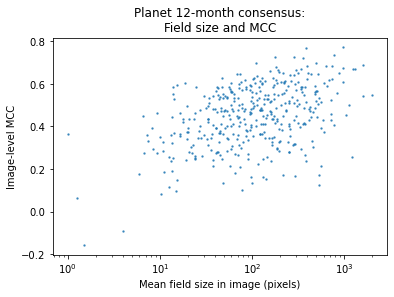

In [105]:
plt.scatter(mean_field_sizes, image_mccs, s=2, alpha=0.7)
plt.xscale('log')
plt.xlabel('Mean field size in image (pixels)')
plt.ylabel('Image-level MCC')
plt.title('Planet 12-month consensus:\nField size and MCC')
plt.show()

In [108]:
from sklearn.linear_model import LinearRegression
reg2 = LinearRegression().fit(np.expand_dims(np.log(np.array(mean_field_sizes)), -1), 
                             np.expand_dims(np.array(image_mccs), -1))
print(reg2.score(np.expand_dims(np.log(np.array(mean_field_sizes)), -1), 
                np.expand_dims(np.array(image_mccs), -1)))
print(reg2.coef_)
print(reg2.intercept_)

0.1849934382545244
[[0.04997062]]
[0.21707524]


## MCC at field level

### Planet consensus

In [71]:
# pred_folder_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus'
pred_folder_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/consensus'

field_mccs = []
field_sizes = []

for image_id in image_ids:
    extent = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_test/{}.png'.format(image_id))
    pred = np.load(os.path.join('../results/india/GeneralBlockchain/', 
                                pred_folder_name,
                                'extent_predictions',
                                '{}.npy'.format(image_id)))
    n_components, numbered = cv2.connectedComponents(extent)
    for i in range(1, n_components):
        one_field = np.array(numbered == i, dtype=np.uint8)
        one_field_flat = one_field.flatten()

        mask = get_mask(one_field)
        mask_flat = mask.flatten()

        indices = np.where(mask_flat == 1)[0]
        field_and_border = one_field_flat[indices]

        pred_flat = pred.flatten()
        prediction = pred_flat[indices]
        prediction = np.array(prediction > 0.5, dtype=np.uint8)

        mcc = matthews_corrcoef(field_and_border, prediction)
        field_mccs.append(mcc)

        size = np.sum(one_field)
        field_sizes.append(size)

/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


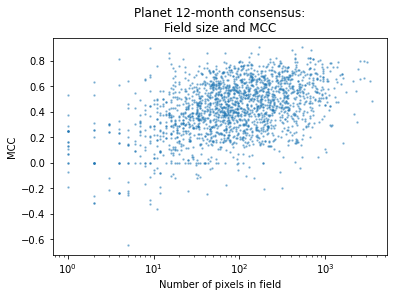

In [76]:
plt.scatter(field_sizes, field_mccs, s=2, alpha=0.4)
plt.xscale('log')
plt.xlabel('Number of pixels in field')
plt.ylabel('MCC')
plt.title('Planet 12-month consensus:\nField size and MCC')
plt.show()

In [111]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.expand_dims(np.log(np.array(field_sizes)), -1), 
                             np.expand_dims(np.array(field_mccs), -1))
print(reg.score(np.expand_dims(np.log(np.array(field_sizes)), -1), 
                np.expand_dims(np.array(field_mccs), -1)))
print(reg.coef_)
print(reg.intercept_)

0.17995360285787
[[0.06546948]]
[0.13540835]


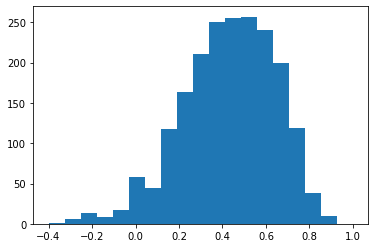

In [72]:
plt.hist(field_mccs, bins=np.linspace(-0.4, 1.0, 20))
plt.show()

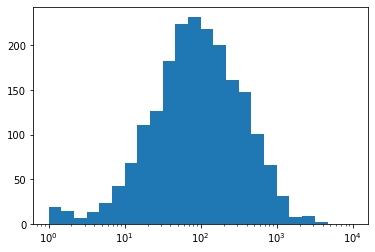

In [73]:
plt.hist(field_sizes, bins=np.logspace(0, 4, 25))
plt.xscale('log')
plt.show()

## IoU at field level

In [2]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

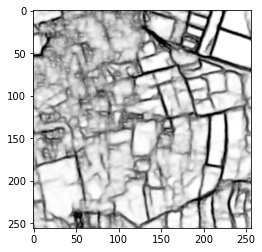

In [6]:
plt.imshow(img, cmap='Greys_r')
plt.show()

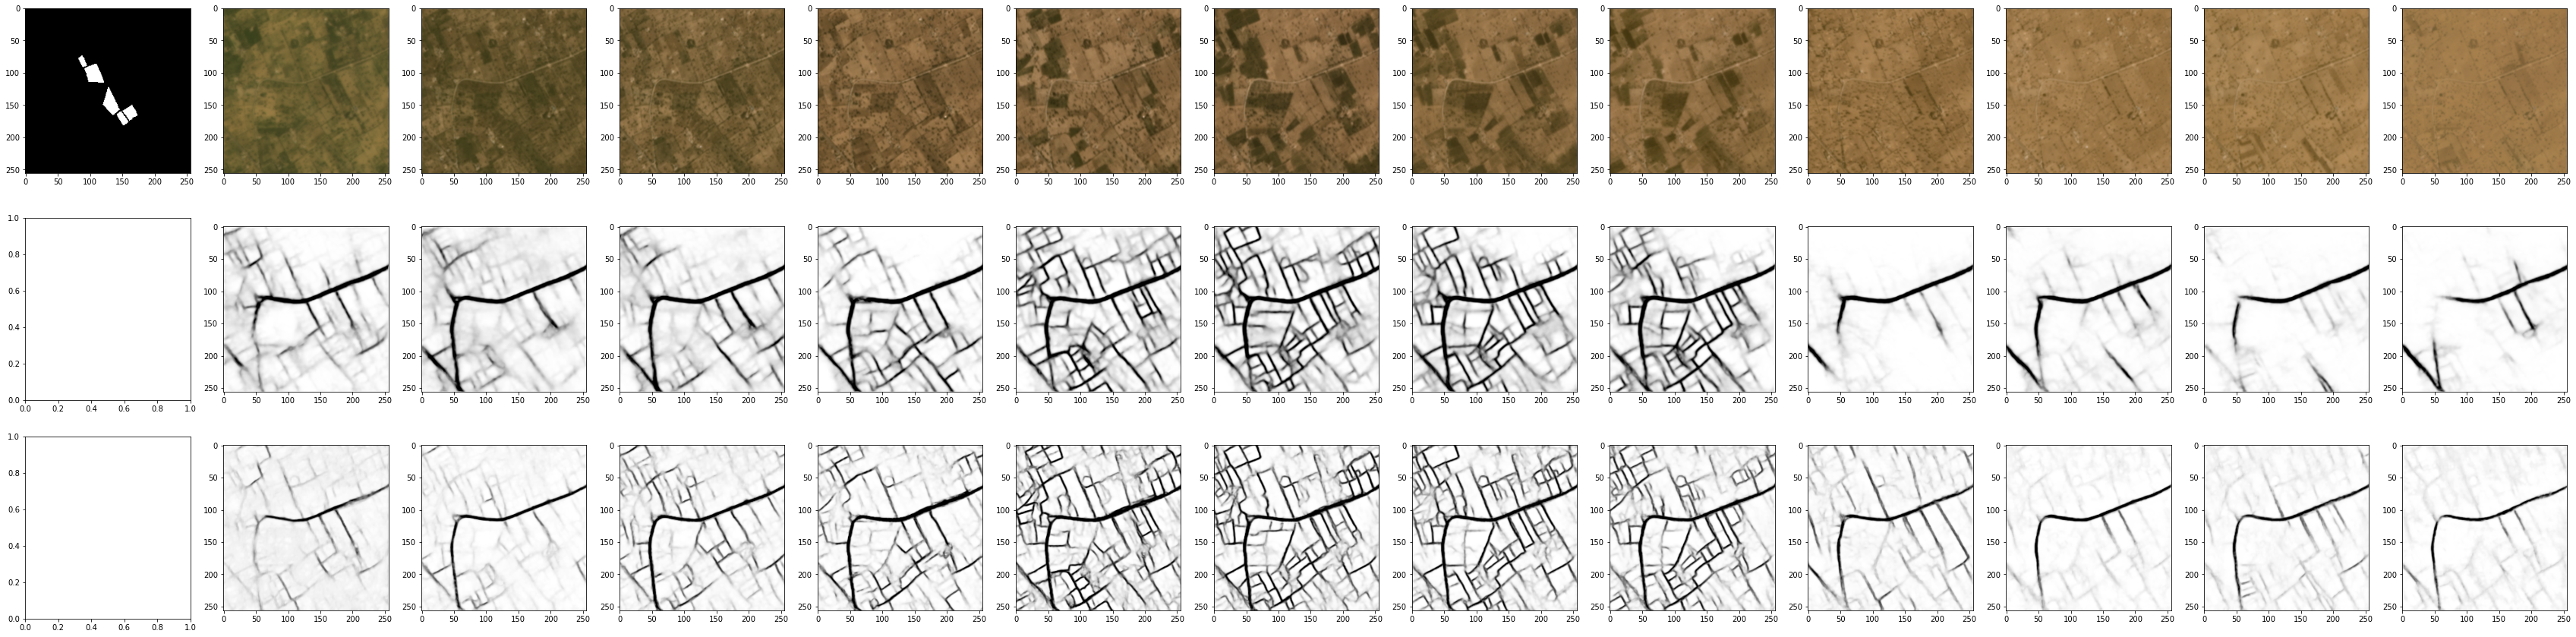

In [125]:
# directly applying France original resolution vs. 2x+3x downsampled
image_id = '0013'
months = ['2020_{}'.format(str(x).zfill(2)) for x in range(8, 13)] + \
         ['2021_{}'.format(str(x).zfill(2)) for x in range(1, 8)]
fig, ax = plt.subplots(3, 13, figsize=(65,15))
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_test/{}.png'.format(image_id))
ax[0,0].imshow(label, cmap='Greys_r')
for m, month in enumerate(months):
    im = imageio.imread('../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_test/{}/{}_{}.tif'.format(month, image_id, month))
    img1 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/{}/extent_predictions/{}_{}.npy'.format(month, image_id, month))
    img2 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/{}/extent_predictions/{}_{}.npy'.format(month, image_id, month))

    ax[0,m+1].imshow(im, cmap='Greys_r')
    ax[1,m+1].imshow(img1, cmap='Greys_r')
    ax[2,m+1].imshow(img2, cmap='Greys_r')
plt.show()

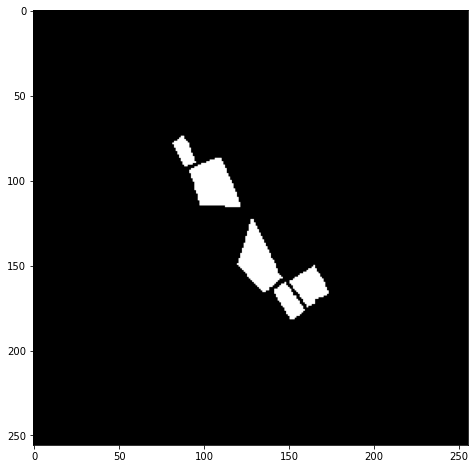

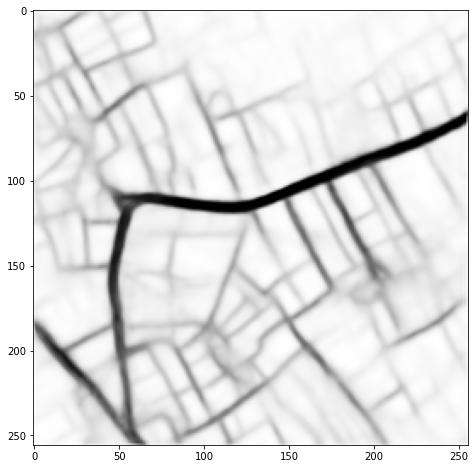

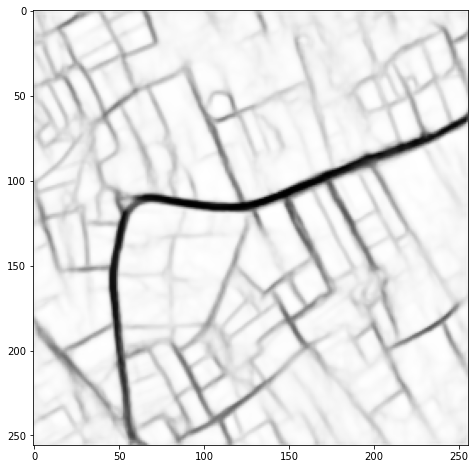

In [126]:
# directly applying France original resolution vs. 2x+3x downsampled
image_id = '0013'
img1 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(image_id))
img2 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(image_id))
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_test/{}.png'.format(image_id))

fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(label, cmap='Greys_r')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(img1, cmap='Greys_r')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.imshow(img2, cmap='Greys_r')
plt.show()

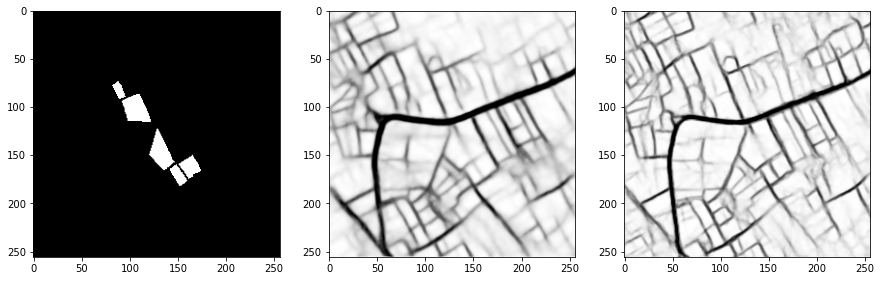

In [134]:
# directly applying France original resolution vs. 2x+3x downsampled
image_id = '0013'
img1 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus_OctDecFeb/extent_predictions/{}.npy'.format(image_id))
img2 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_OctDecFeb/extent_predictions/{}.npy'.format(image_id))
label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_test/{}.png'.format(image_id))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(label, cmap='Greys_r')
ax[1].imshow(img1, cmap='Greys_r')
ax[2].imshow(img2, cmap='Greys_r')
plt.show()